# 投球分類モデル: データパイプライン再構築（投手ID付き）
**作成日**: 2026/01/14
**目的**: 投手IDを最初から含めたデータパイプラインを構築し、投手相対評価特徴量を追加する。
**出力CSVファイル**: `train_pitcher_v2.csv`, `test_pitcher_v2.csv`

## 処理フロー
1. pybaseballからデータ取得（pitcher列含む）
2. 利き腕による正規化
3. 既存の特徴量エンジニアリング（asao_1313と同じ）
4. 投手相対評価特徴量の追加（新規）
5. train/test分割・CSV保存
6. モデル学習・評価


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore')

from pybaseball import statcast, cache
cache.enable()

plt.rcParams['font.family'] = 'sans-serif'
print("Libraries loaded.")


Libraries loaded.


In [11]:
# === Step 1: pybaseballからデータ取得 ===
print("Fetching data from pybaseball (2023年シーズン)...")
print("これには5-10分かかる場合があります...")

df_raw = statcast(start_dt='2023-04-01', end_dt='2023-10-01')
print(f"Raw data shape: {df_raw.shape}")

# 必要なカラムを選択（pitcher列を含める！）
required_cols = [
    'pitcher', 'p_throws', 'pitch_type',
    'release_speed', 'release_spin_rate', 'spin_axis',
    'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z'
]

# 存在するカラムのみ選択
available_cols = [col for col in required_cols if col in df_raw.columns]
print(f"Available columns: {available_cols}")

df = df_raw[available_cols].copy()
df = df.dropna()
print(f"After dropna: {df.shape}")


Fetching data from pybaseball (2023年シーズン)...
これには5-10分かかる場合があります...
This is a large query, it may take a moment to complete


100%|██████████| 184/184 [00:03<00:00, 60.24it/s]


Raw data shape: (714703, 118)
Available columns: ['pitcher', 'p_throws', 'pitch_type', 'release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z']
After dropna: (707792, 10)


In [12]:
# === Step 2: ピッチタイプのフィルタリング ===
# asao_1313と同じ球種のみを使用

valid_pitches = ['CH', 'CU', 'EP', 'FA', 'FC', 'FF', 'FO', 'FS', 'KC', 'KN', 'SI', 'SL', 'ST', 'SV']
df = df[df['pitch_type'].isin(valid_pitches)]
print(f"After pitch type filter: {df.shape}")
print("Pitch type distribution:")
print(df['pitch_type'].value_counts())


After pitch type filter: (707604, 10)
Pitch type distribution:
pitch_type
FF    227251
SL    113741
SI    109470
CH     76887
FC     55989
CU     46916
ST     41350
FS     15863
KC     14699
SV      2810
FA      1113
FO       766
EP       557
KN       192
Name: count, dtype: int64


In [13]:
# === Step 3: 利き腕による正規化 ===
# 左投手のpfx_x, release_pos_x, spin_axisを反転

def normalize_by_handedness(df):
    df = df.copy()
    left_mask = df['p_throws'] == 'L'
    
    # 横変化を反転
    df.loc[left_mask, 'pfx_x'] = -df.loc[left_mask, 'pfx_x']
    df.loc[left_mask, 'release_pos_x'] = -df.loc[left_mask, 'release_pos_x']
    
    # 回転軸を反転
    df.loc[left_mask, 'spin_axis'] = 360 - df.loc[left_mask, 'spin_axis']
    
    return df

df = normalize_by_handedness(df)
print("Handedness normalization applied.")


Handedness normalization applied.


In [14]:
# === Step 4: 特徴量エンジニアリング（asao_1313と同じ） ===

# 1. normalized_spin_axis
df['normalized_spin_axis'] = df['spin_axis'] / 360.0

# 2. movement_angle
df['movement_angle'] = np.arctan2(df['pfx_z'], df['pfx_x']) * 180 / np.pi

# 3. abs_horizontal_movement
df['abs_horizontal_movement'] = df['pfx_x'].abs()

# 4. movement_magnitude
df['movement_magnitude'] = np.sqrt(df['pfx_x']**2 + df['pfx_z']**2)

# 5. spin_efficiency (仮の計算: movement_magnitude / spin_rate * 1000)
df['spin_efficiency'] = df['movement_magnitude'] / (df['release_spin_rate'] + 1) * 1000

# 6. speed_spin_ratio
df['speed_spin_ratio'] = df['release_speed'] / (df['release_spin_rate'] + 1)

# 7. horizontal_vertical_ratio
df['horizontal_vertical_ratio'] = df['pfx_x'] / (df['pfx_z'].abs() + 0.1)

# 8. release_position_magnitude
df['release_position_magnitude'] = np.sqrt(df['release_pos_x']**2 + df['release_pos_z']**2)

# 9. vertical_rise (pfx_z > 0 の部分)
df['vertical_rise'] = df['pfx_z'].clip(lower=0)

# 10. sink_rate (pfx_z < 0 の絶対値)
df['sink_rate'] = (-df['pfx_z']).clip(lower=0)

# 11. spin_axis_deviation_from_fastball (仮: 180度からの偏差)
df['spin_axis_deviation_from_fastball'] = abs(df['spin_axis'] - 180)

# 12. velocity_times_pfx_z (FS/CH識別用)
df['velocity_times_pfx_z'] = df['release_speed'] * df['pfx_z']

# 13. velocity_abs_pfx_x_ratio (FC/SL識別用)
df['velocity_abs_pfx_x_ratio'] = df['release_speed'] / (df['pfx_x'].abs() + 0.1)

# 14. pfx_z_minus_abs_pfx_x
df['pfx_z_minus_abs_pfx_x'] = df['pfx_z'] - df['pfx_x'].abs()

print("Feature engineering completed (14 features).")
print(f"Current columns: {len(df.columns)}")


Feature engineering completed (14 features).
Current columns: 24


In [15]:
# === Step 5: 投手相対評価特徴量（新規） ===

# 投手ごとの平均統計量を計算
pitcher_stats = df.groupby('pitcher').agg({
    'release_speed': 'mean',
    'release_spin_rate': 'mean',
    'pfx_x': 'mean',
    'pfx_z': 'mean'
}).rename(columns={
    'release_speed': 'pitcher_avg_speed',
    'release_spin_rate': 'pitcher_avg_spin',
    'pfx_x': 'pitcher_avg_pfx_x',
    'pfx_z': 'pitcher_avg_pfx_z'
})

print(f"Calculated stats for {len(pitcher_stats)} pitchers")

# マージ
df = df.merge(pitcher_stats, on='pitcher', how='left')

# 相対特徴量を計算
df['speed_diff'] = df['release_speed'] - df['pitcher_avg_speed']
df['spin_diff'] = df['release_spin_rate'] - df['pitcher_avg_spin']
df['pfx_x_diff'] = df['pfx_x'] - df['pitcher_avg_pfx_x']
df['pfx_z_diff'] = df['pfx_z'] - df['pitcher_avg_pfx_z']

print("Pitcher-relative features added.")
print(df[['speed_diff', 'spin_diff', 'pfx_x_diff', 'pfx_z_diff']].describe())


Calculated stats for 862 pitchers
Pitcher-relative features added.
       speed_diff    spin_diff  pfx_x_diff  pfx_z_diff
count    707604.0     707604.0    707604.0    707604.0
mean          0.0          0.0         0.0         0.0
std      5.303251   274.067231    0.762292    0.664427
min    -36.281404 -1987.641181   -2.888528   -2.953671
25%     -4.380622  -116.022124   -0.566208   -0.414908
50%      1.329509    29.753121   -0.162345    0.086165
75%       4.53604   161.612139    0.581181    0.521352
max     37.173333  1449.777778    2.872248    1.888631


In [16]:
# === Step 6: train/test分割とCSV保存 ===

# 特徴量リスト（asao_1313と同じ + 投手相対特徴量）
feature_cols = [
    # 基本特徴量
    'release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z',
    'release_pos_x', 'release_pos_z', 'p_throws',
    # エンジニアリング特徴量
    'normalized_spin_axis', 'movement_angle', 'abs_horizontal_movement',
    'movement_magnitude', 'spin_efficiency', 'speed_spin_ratio',
    'horizontal_vertical_ratio', 'release_position_magnitude',
    'vertical_rise', 'sink_rate', 'spin_axis_deviation_from_fastball',
    'velocity_times_pfx_z', 'velocity_abs_pfx_x_ratio', 'pfx_z_minus_abs_pfx_x',
    # 投手相対特徴量（新規）
    'speed_diff', 'spin_diff', 'pfx_x_diff', 'pfx_z_diff',
    # 投手ID（必要に応じて）
    'pitcher'
]

# 保存用カラム
save_cols = feature_cols + ['pitch_type']
df_save = df[save_cols].copy()

# train/test分割（70:30、asao_1313と同じ）
train_df, test_df = train_test_split(
    df_save, 
    test_size=0.3, 
    random_state=42, 
    stratify=df_save['pitch_type']
)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# CSV保存
train_df.to_csv('train_pitcher_v2.csv', index=False)
test_df.to_csv('test_pitcher_v2.csv', index=False)
print("Saved: train_pitcher_v2.csv, test_pitcher_v2.csv")


Train shape: (495322, 28)
Test shape: (212282, 28)
Saved: train_pitcher_v2.csv, test_pitcher_v2.csv


In [17]:
# === Step 7: モデル学習 ===

# 学習用特徴量（pitcher列とp_throwsは文字列なので除外）
model_features = [
    'release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z',
    'release_pos_x', 'release_pos_z',
    'normalized_spin_axis', 'movement_angle', 'abs_horizontal_movement',
    'movement_magnitude', 'spin_efficiency', 'speed_spin_ratio',
    'horizontal_vertical_ratio', 'release_position_magnitude',
    'vertical_rise', 'sink_rate', 'spin_axis_deviation_from_fastball',
    'velocity_times_pfx_z', 'velocity_abs_pfx_x_ratio', 'pfx_z_minus_abs_pfx_x',
    'speed_diff', 'spin_diff', 'pfx_x_diff', 'pfx_z_diff'
]

target = 'pitch_type'

# データ準備
le = LabelEncoder()
y_train = le.fit_transform(train_df[target])
y_test = le.transform(test_df[target])
X_train = train_df[model_features]
X_test = test_df[model_features]

# 欠損値確認
print(f"X_train NaN count: {X_train.isna().sum().sum()}")

# モデル学習（asao_1313のGridSearch最適パラメータ）
print("Training XGBoost (optimized)...")
model_xgb = xgb.XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, min_child_weight=0.5, n_jobs=-1, random_state=42)
model_xgb.fit(X_train, y_train)

print("Training LightGBM (optimized)...")
model_lgbm = lgbm.LGBMClassifier(n_estimators=100, max_depth=7, learning_rate=0.05, n_jobs=-1, random_state=42, verbose=-1)
model_lgbm.fit(X_train, y_train)

print("Training RandomForest (optimized)...")
model_rf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_leaf=1, n_jobs=-1, random_state=42)
model_rf.fit(X_train, y_train)

# Ensemble
p_xgb = model_xgb.predict_proba(X_test)
p_lgbm = model_lgbm.predict_proba(X_test)
p_rf = model_rf.predict_proba(X_test)

p_ensemble = (p_xgb + p_lgbm + p_rf) / 3.0
y_pred = np.argmax(p_ensemble, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n=== Results with Pitcher-Relative Features (Full Pipeline) ===")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1: {f1:.4f}")
print(f"\nBaseline (asao_1313): Acc 0.924, F1 0.923")
print(f"Improvement: Acc {acc - 0.924:+.4f}, F1 {f1 - 0.923:+.4f}")


X_train NaN count: 0
Training XGBoost (optimized)...
Training LightGBM (optimized)...
Training RandomForest (optimized)...

=== Results with Pitcher-Relative Features (Full Pipeline) ===
Accuracy: 0.9402
Weighted F1: 0.9400

Baseline (asao_1313): Acc 0.924, F1 0.923
Improvement: Acc +0.0162, F1 +0.0170


              precision    recall  f1-score   support

          CH       0.96      0.98      0.97     23066
          CU       0.93      0.93      0.93     14075
          EP       0.93      0.87      0.90       167
          FA       0.93      0.92      0.93       334
          FC       0.89      0.84      0.87     16797
          FF       0.97      0.98      0.98     68175
          FO       0.87      0.87      0.87       230
          FS       0.94      0.84      0.89      4759
          KC       0.96      0.83      0.89      4410
          KN       0.86      0.95      0.90        58
          SI       0.96      0.95      0.96     32841
          SL       0.89      0.92      0.90     34122
          ST       0.88      0.90      0.89     12405
          SV       0.94      0.78      0.85       843

    accuracy                           0.94    212282
   macro avg       0.92      0.90      0.91    212282
weighted avg       0.94      0.94      0.94    212282


=== Key Metrics ===
FC R

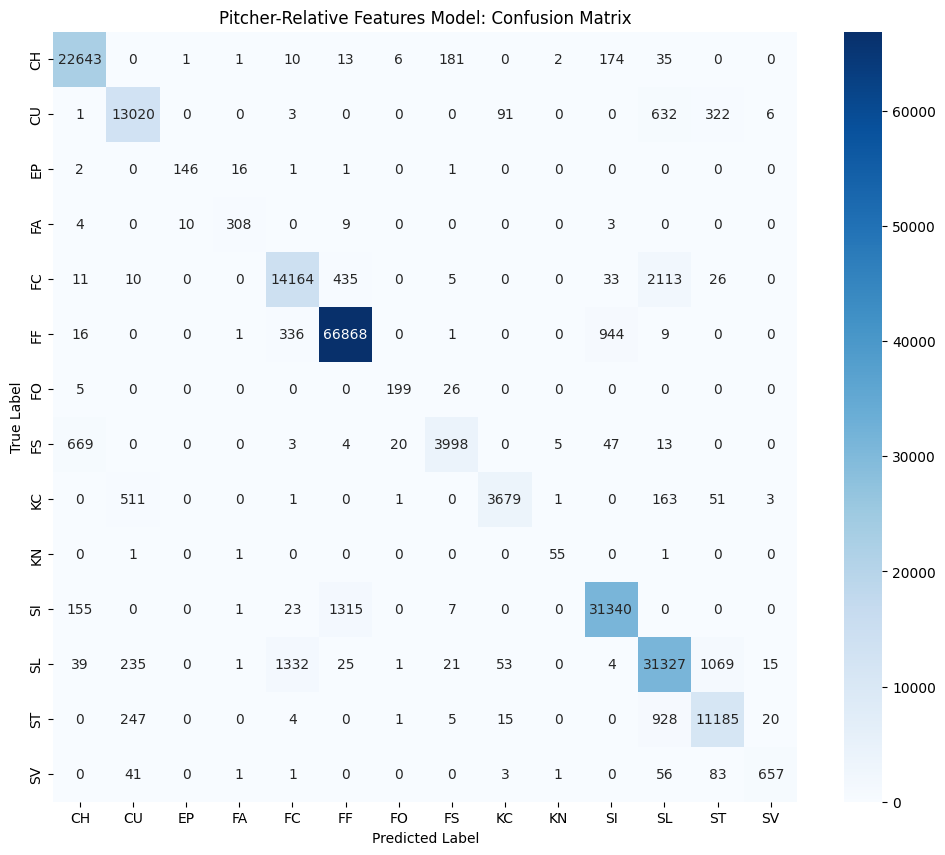

In [18]:
# === Step 8: 詳細評価 ===
print(classification_report(y_test, y_pred, target_names=le.classes_))

# FC/SI Analysis
fc_report = classification_report(y_test, y_pred, output_dict=True, target_names=le.classes_)
print(f"\n=== Key Metrics ===")
print(f"FC Recall: {fc_report['FC']['recall']:.4f} (Baseline: 0.76)")
print(f"SI Recall: {fc_report['SI']['recall']:.4f} (Baseline: 0.94)")

# Feature Importance
importance = pd.DataFrame({
    'feature': model_features,
    'importance': model_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Feature Importance (Top 10) ===")
print(importance.head(10))

print("\n=== Pitcher-Relative Features Importance ===")
pitcher_feats = ['speed_diff', 'spin_diff', 'pfx_x_diff', 'pfx_z_diff']
print(importance[importance['feature'].isin(pitcher_feats)])

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Pitcher-Relative Features Model: Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
